# Model A 

This is a script showing results of **model A** in the ablation studies. The model is built using the following configuration:

- **Backbone:** LightGCN
- **Graph type:** Homogeneous
- **Loss function:** Bayesian personalized ranking
- **Embeddings used:** No
- **Research trends used:** No
- **Lead author flag used:** No

*Primarily, the model is used as a baseline without using article and author contextual embeddings.*

## **Setting up environment**

---



### Loading libraries

In [27]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.models.lightgcn import LightGCN
from torch.optim.lr_scheduler import LRScheduler

from util.homogeneous.dataset import DatasetEuCoHM
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate,
    get_results
)

### Global variables

In [28]:
# Model name
model_name = 'A'
# Dataset save filepath
dataset_save_filepath = '../data/dataset_homogeneous.pkl'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=64,
    learning_rate=1e-2,
    num_layers=2,
    num_epochs=50,
    num_recommendations=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Loading dataset

---


In [3]:
# Add the object as a safe global to shut down warning
torch.serialization.add_safe_globals([DatasetEuCoHM])
# Open the dataset file and save it to variable
with open(dataset_save_filepath, 'rb') as file:
    dataset: DatasetEuCoHM = pickle.load(file)

data = dataset.data
author_id_map = dataset.author_id_map
author_node_id_map = dataset.author_node_id_map

/home/eucollab/eutopia-colllaboration/ecr-recommender/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

## Model training


---



### Model definition

In [24]:
class ModelEuCoA(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )
        # Setup LightGCN baseline
        self.model = LightGCN(num_nodes=input_channels,
                              embedding_dim=hidden_channels,
                              num_layers=self.num_layers).to(device)

    def get_embedding(self,
                      x: Tensor,
                      edge_index: Adj) -> Tensor:
        return self.model.get_embedding(edge_index=edge_index)

    def forward(self,
                x: Tensor,
                edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        return self.model(edge_index, edge_label_index)

    def recommendation_loss(self,
                            x: Tensor,
                            edge_index: Adj,
                            pos_edge_rank: Tensor,
                            neg_edge_rank: Tensor,
                            node_id: Optional[Tensor] = None,
                            lambda_reg: float = 1e-4) -> Tensor:
        return self.model.recommendation_loss(pos_edge_rank=pos_edge_rank,
                                              neg_edge_rank=neg_edge_rank,
                                              node_id=node_id)

### Training the model

In [25]:
# Initialize the model
model = ModelEuCoA(
    input_channels=data.num_nodes,
    hidden_channels=model_config['hidden_channels'],
    num_recommendations=model_config['num_recommendations'],
    num_layers=model_config['num_layers'],
    author_node_id_map=author_node_id_map,
    author_id_map=author_id_map
).to(device)

# Transfer to device
data = data.to(device)

# Initialize the optimizer
optimizer: Optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=model_config['learning_rate']
)

# Initialize the scheduler
scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=10
)

In [26]:
results: list = list()
for epoch in range(1, model_config['num_epochs'] + 1):
    # ------ Train
    train_loss: float = train(
        model=model,
        data=data,
        optimizer=optimizer
    )
    # ------ Test
    test_loss: float = test(
        model=model,
        data=data
    )
    scheduler.step(test_loss)
    # ------ Evaluate
    evaluation_results: dict = evaluate(
        k=model_config['num_recommendations'],
        model=model,
        data=data
    )

    # Save results
    epoch_result = get_results(
        epoch=epoch,
        train_loss=train_loss,
        test_loss=test_loss,
        evaluation_results=evaluation_results
    )
    results.append(epoch_result)

Epoch 1, train loss: 0.6931, test loss: 0.6930, precision@k: 0.0186, recall@k: 0.0589, MAP@k: 0.0269, MRR@k: 0.0486, NDCG@k: 0.0416, HitRate@k: 0.1112
Epoch 2, train loss: 0.6911, test loss: 0.6927, precision@k: 0.0198, recall@k: 0.0645, MAP@k: 0.0303, MRR@k: 0.0546, NDCG@k: 0.0462, HitRate@k: 0.1210
Epoch 3, train loss: 0.6858, test loss: 0.6920, precision@k: 0.0200, recall@k: 0.0652, MAP@k: 0.0310, MRR@k: 0.0554, NDCG@k: 0.0469, HitRate@k: 0.1223
Epoch 4, train loss: 0.6763, test loss: 0.6909, precision@k: 0.0199, recall@k: 0.0645, MAP@k: 0.0310, MRR@k: 0.0556, NDCG@k: 0.0468, HitRate@k: 0.1214
Epoch 5, train loss: 0.6621, test loss: 0.6895, precision@k: 0.0199, recall@k: 0.0645, MAP@k: 0.0308, MRR@k: 0.0558, NDCG@k: 0.0467, HitRate@k: 0.1219
Epoch 6, train loss: 0.6431, test loss: 0.6877, precision@k: 0.0196, recall@k: 0.0641, MAP@k: 0.0304, MRR@k: 0.0551, NDCG@k: 0.0462, HitRate@k: 0.1211
Epoch 7, train loss: 0.6191, test loss: 0.6855, precision@k: 0.0195, recall@k: 0.0639, MAP@k: 

### Model evaluation

In [31]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model{model_name}.csv', index=False)

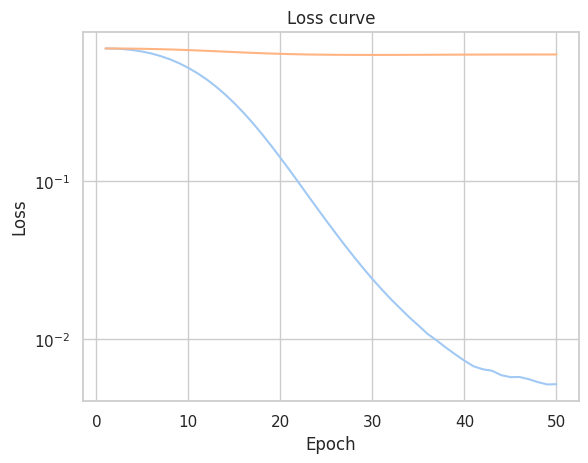

In [18]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss')
# Test loss
sns.lineplot(data=results_df, x='Epoch', y='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.show()

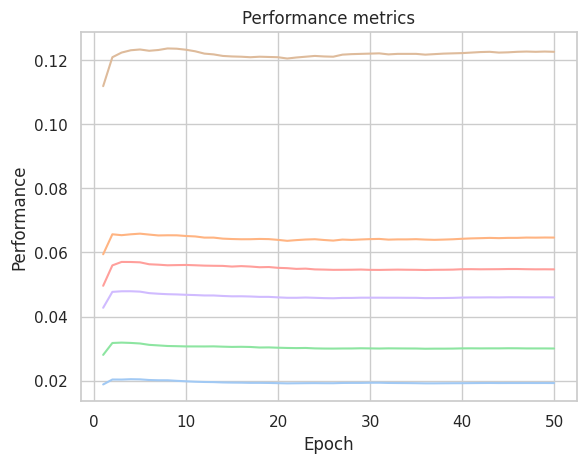

In [30]:
# Generate evaluation metrics plot
sns.lineplot(data=results_df, x='Epoch', y='Precision@k')
sns.lineplot(data=results_df, x='Epoch', y='Recall@k')
sns.lineplot(data=results_df, x='Epoch', y='MAP@k')
sns.lineplot(data=results_df, x='Epoch', y='MRR@k')
sns.lineplot(data=results_df, x='Epoch', y='NDCG@k')
sns.lineplot(data=results_df, x='Epoch', y='HitRate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Performance metrics')
plt.show()
